In [3]:
import glob
import os
from typing import Any, Dict, List, Tuple, Union

import torch
import yaml
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder, VisionDataset

from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from model import CustomVGG
import torchvision

In [4]:
device = 'cuda'
lr = 0.0001
num_epoch = 100
l1_weight = 0.01

input_size = 128
batch_size = 128
n_worker = 8

In [5]:
import torchvision.transforms.functional as TF
import random

class MyRotationTransform:
    """Rotate by one of the given angles."""

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)

rotation_transform = MyRotationTransform(angles=[0, 180, 90, 270])

In [6]:
normalize = transforms.Normalize(mean= [0.485, 0.456, 0.406],
                                 std= [0.229, 0.224, 0.225])

train_dataset = ImageFolder(
    "/opt/ml/data/train", transforms.Compose([
        transforms.Resize((input_size, input_size)),
        #transforms.RandomCrop(input_size),
        transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(brightness=0.5, contrast=0.2, saturation=0.5, hue=0.1),
        MyRotationTransform(angles=[0, 180, 90, 270]),
        transforms.ToTensor(),
        normalize,
    ]))

val_dataset = ImageFolder("/opt/ml/data/val", transforms.Compose([
        transforms.Resize((input_size, input_size)),
        #transforms.Resize(int(input_size/0.875)),
        #transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        normalize,
    ]))

In [7]:
from torch.utils.data.sampler import WeightedRandomSampler

sample_freq = [1169, 4826, 1020, 2655, 4879, 1092] #[0] * len(train_dataset.classes) #df_ff.gender.value_counts().sort_index().to_numpy()
sample_weight = np.concatenate([[1/f]*f for f in sample_freq])
sample_weight = torch.from_numpy(sample_weight)
sampler = WeightedRandomSampler(sample_weight.type('torch.DoubleTensor'), len(sample_weight)//2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


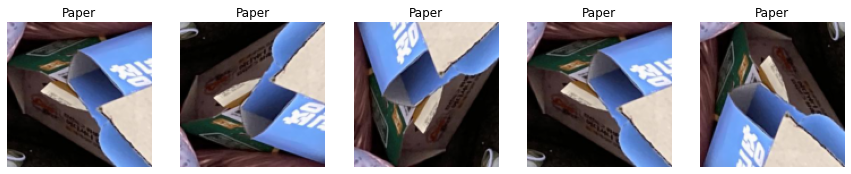

In [42]:
idx = np.random.randint(0, len(train_dataset))

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img, label = train_dataset[idx]
    img = img.permute(1,2,0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    axes[i].imshow(img)
    axes[i].set_title(train_dataset.classes[label])
    axes[i].axis('off')
plt.show()

In [9]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size, drop_last=True, sampler = sampler,
    num_workers=n_worker)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size, shuffle=False,
    num_workers=n_worker)

dataloaders = { 'train' : train_loader, 'valid' : val_loader}

In [10]:
model = CustomVGG()
model.to(device)
model.load_state_dict(torch.load('save/vgg9_112.pt'))

<All keys matched successfully>

In [13]:
model = torchvision.models.vgg19_bn(pretrained=True)
with torch.no_grad():
    for m in model.features:
        if isinstance(m, torch.nn.Conv2d):
            m.bias = None
        # elif isinstance(m, torch.nn.BatchNorm2d):
        #     m.weight.fill_(0.5)
model.avgpool = torch.nn.AvgPool2d(4)
model.classifier = torch.nn.Linear(512, 6)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [25]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', verbose=True, patience=5) # optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60, eta_min=0.000001)#

In [26]:
from trainer_reg import Trainer

trainer = Trainer('/opt/ml/code/save', seed=42)

In [27]:
trainer.train(model, dataloaders, criterion, optimizer, lr_scheduler, num_epoch, 10, l1_weight, 'test')

Epoch 1/100
----------


100%|██████████| 61/61 [00:23<00:00,  2.57it/s]


train Epoch: 1 Loss: 1.7897 Acc: 0.1710 F1: 0.0920


100%|██████████| 41/41 [00:14<00:00,  2.80it/s]


valid Epoch: 1 Loss: 1.7822 Acc: 0.3044 F1: 0.1276

Epoch 2/100
----------


100%|██████████| 61/61 [00:21<00:00,  2.78it/s]


train Epoch: 2 Loss: 1.7681 Acc: 0.1998 F1: 0.1137


100%|██████████| 41/41 [00:14<00:00,  2.78it/s]


valid Epoch: 2 Loss: 1.7848 Acc: 0.3040 F1: 0.1393

Epoch 3/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.67it/s]


train Epoch: 3 Loss: 1.7415 Acc: 0.2339 F1: 0.1324


100%|██████████| 41/41 [00:14<00:00,  2.78it/s]


valid Epoch: 3 Loss: 1.7793 Acc: 0.3237 F1: 0.1453

Epoch 4/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.70it/s]


train Epoch: 4 Loss: 1.7178 Acc: 0.2514 F1: 0.1601


100%|██████████| 41/41 [00:14<00:00,  2.87it/s]


valid Epoch: 4 Loss: 1.7877 Acc: 0.2969 F1: 0.1612

Epoch 5/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.68it/s]


train Epoch: 5 Loss: 1.6931 Acc: 0.2738 F1: 0.1910


100%|██████████| 41/41 [00:14<00:00,  2.82it/s]


valid Epoch: 5 Loss: 1.7533 Acc: 0.3153 F1: 0.1848

Epoch 6/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.70it/s]


train Epoch: 6 Loss: 1.6623 Acc: 0.2888 F1: 0.2115


100%|██████████| 41/41 [00:14<00:00,  2.87it/s]


valid Epoch: 6 Loss: 1.7247 Acc: 0.3247 F1: 0.2413

Epoch 7/100
----------


100%|██████████| 61/61 [00:23<00:00,  2.57it/s]


train Epoch: 7 Loss: 1.5873 Acc: 0.3336 F1: 0.2903


100%|██████████| 41/41 [00:14<00:00,  2.82it/s]


valid Epoch: 7 Loss: 1.6849 Acc: 0.3184 F1: 0.2572

Epoch 8/100
----------


100%|██████████| 61/61 [00:23<00:00,  2.60it/s]


train Epoch: 8 Loss: 1.5298 Acc: 0.3689 F1: 0.3419


100%|██████████| 41/41 [00:14<00:00,  2.85it/s]


valid Epoch: 8 Loss: 1.6581 Acc: 0.3090 F1: 0.2902

Epoch 9/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.76it/s]


train Epoch: 9 Loss: 1.4486 Acc: 0.4224 F1: 0.4011


100%|██████████| 41/41 [00:14<00:00,  2.75it/s]


valid Epoch: 9 Loss: 1.6261 Acc: 0.3759 F1: 0.3419

Epoch 10/100
----------


100%|██████████| 61/61 [00:23<00:00,  2.62it/s]


train Epoch: 10 Loss: 1.3759 Acc: 0.4668 F1: 0.4476


100%|██████████| 41/41 [00:14<00:00,  2.77it/s]


valid Epoch: 10 Loss: 1.5596 Acc: 0.3861 F1: 0.3614

Epoch 11/100
----------


100%|██████████| 61/61 [00:23<00:00,  2.61it/s]


train Epoch: 11 Loss: 1.3021 Acc: 0.5035 F1: 0.4933


100%|██████████| 41/41 [00:14<00:00,  2.89it/s]


valid Epoch: 11 Loss: 1.3346 Acc: 0.5135 F1: 0.4627

Epoch 12/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.69it/s]


train Epoch: 12 Loss: 1.2624 Acc: 0.5154 F1: 0.5089


100%|██████████| 41/41 [00:15<00:00,  2.68it/s]


valid Epoch: 12 Loss: 1.3157 Acc: 0.5139 F1: 0.4781

Epoch 13/100
----------


100%|██████████| 61/61 [00:23<00:00,  2.56it/s]


train Epoch: 13 Loss: 1.2058 Acc: 0.5341 F1: 0.5314


100%|██████████| 41/41 [00:14<00:00,  2.86it/s]


valid Epoch: 13 Loss: 1.2598 Acc: 0.5135 F1: 0.4690

Epoch 14/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.68it/s]


train Epoch: 14 Loss: 1.1604 Acc: 0.5639 F1: 0.5605


100%|██████████| 41/41 [00:15<00:00,  2.65it/s]


valid Epoch: 14 Loss: 1.2060 Acc: 0.5425 F1: 0.5032

Epoch 15/100
----------


100%|██████████| 61/61 [00:24<00:00,  2.47it/s]


train Epoch: 15 Loss: 1.1295 Acc: 0.5704 F1: 0.5665


100%|██████████| 41/41 [00:14<00:00,  2.80it/s]


valid Epoch: 15 Loss: 1.2834 Acc: 0.5003 F1: 0.4719

Epoch 16/100
----------


100%|██████████| 61/61 [00:23<00:00,  2.56it/s]


train Epoch: 16 Loss: 1.0951 Acc: 0.5931 F1: 0.5889


100%|██████████| 41/41 [00:14<00:00,  2.83it/s]


valid Epoch: 16 Loss: 1.1550 Acc: 0.5686 F1: 0.5278

Epoch 17/100
----------


100%|██████████| 61/61 [00:23<00:00,  2.56it/s]


train Epoch: 17 Loss: 1.0742 Acc: 0.5912 F1: 0.5853


100%|██████████| 41/41 [00:15<00:00,  2.69it/s]


valid Epoch: 17 Loss: 1.1780 Acc: 0.5592 F1: 0.5233

Epoch 18/100
----------


100%|██████████| 61/61 [00:24<00:00,  2.49it/s]


train Epoch: 18 Loss: 1.0307 Acc: 0.6098 F1: 0.6054


100%|██████████| 41/41 [00:14<00:00,  2.85it/s]


valid Epoch: 18 Loss: 1.0973 Acc: 0.5882 F1: 0.5530

Epoch 19/100
----------


100%|██████████| 61/61 [00:23<00:00,  2.64it/s]


train Epoch: 19 Loss: 1.0191 Acc: 0.6135 F1: 0.6094


100%|██████████| 41/41 [00:16<00:00,  2.45it/s]


valid Epoch: 19 Loss: 1.0964 Acc: 0.5888 F1: 0.5317

Epoch 20/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.66it/s]


train Epoch: 20 Loss: 1.0118 Acc: 0.6154 F1: 0.6133


100%|██████████| 41/41 [00:14<00:00,  2.76it/s]


valid Epoch: 20 Loss: 1.1169 Acc: 0.5711 F1: 0.5362

Epoch 21/100
----------


100%|██████████| 61/61 [00:24<00:00,  2.52it/s]


train Epoch: 21 Loss: 1.0024 Acc: 0.6273 F1: 0.6257


100%|██████████| 41/41 [00:14<00:00,  2.77it/s]


valid Epoch: 21 Loss: 1.1181 Acc: 0.5759 F1: 0.5142

Epoch 22/100
----------


100%|██████████| 61/61 [00:23<00:00,  2.61it/s]


train Epoch: 22 Loss: 0.9717 Acc: 0.6442 F1: 0.6432


100%|██████████| 41/41 [00:14<00:00,  2.88it/s]


valid Epoch: 22 Loss: 1.1322 Acc: 0.5717 F1: 0.5330

Epoch 23/100
----------


100%|██████████| 61/61 [00:23<00:00,  2.65it/s]


train Epoch: 23 Loss: 0.9436 Acc: 0.6472 F1: 0.6443


100%|██████████| 41/41 [00:14<00:00,  2.75it/s]


valid Epoch: 23 Loss: 1.1608 Acc: 0.5625 F1: 0.5276

Epoch 24/100
----------


100%|██████████| 61/61 [00:21<00:00,  2.78it/s]


train Epoch: 24 Loss: 0.9619 Acc: 0.6405 F1: 0.6372


100%|██████████| 41/41 [00:14<00:00,  2.81it/s]


valid Epoch: 24 Loss: 1.0801 Acc: 0.6010 F1: 0.5492
Epoch    24: reducing learning rate of group 0 to 1.0000e-05.

Epoch 25/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.72it/s]


train Epoch: 25 Loss: 0.9226 Acc: 0.6559 F1: 0.6531


100%|██████████| 41/41 [00:15<00:00,  2.73it/s]


valid Epoch: 25 Loss: 1.0323 Acc: 0.6156 F1: 0.5693

Epoch 26/100
----------


100%|██████████| 61/61 [00:24<00:00,  2.52it/s]


train Epoch: 26 Loss: 0.8871 Acc: 0.6747 F1: 0.6711


100%|██████████| 41/41 [00:14<00:00,  2.83it/s]


valid Epoch: 26 Loss: 1.0198 Acc: 0.6160 F1: 0.5749

Epoch 27/100
----------


100%|██████████| 61/61 [00:24<00:00,  2.53it/s]


train Epoch: 27 Loss: 0.8988 Acc: 0.6660 F1: 0.6638


100%|██████████| 41/41 [00:14<00:00,  2.78it/s]


valid Epoch: 27 Loss: 1.0122 Acc: 0.6187 F1: 0.5785

Epoch 28/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.73it/s]


train Epoch: 28 Loss: 0.8979 Acc: 0.6637 F1: 0.6622


100%|██████████| 41/41 [00:14<00:00,  2.87it/s]


valid Epoch: 28 Loss: 1.0312 Acc: 0.6095 F1: 0.5682

Epoch 29/100
----------


100%|██████████| 61/61 [00:24<00:00,  2.49it/s]


train Epoch: 29 Loss: 0.8867 Acc: 0.6756 F1: 0.6732


100%|██████████| 41/41 [00:15<00:00,  2.73it/s]


valid Epoch: 29 Loss: 1.0192 Acc: 0.6166 F1: 0.5749

Epoch 30/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.74it/s]


train Epoch: 30 Loss: 0.8808 Acc: 0.6764 F1: 0.6734


100%|██████████| 41/41 [00:14<00:00,  2.85it/s]


valid Epoch: 30 Loss: 1.0130 Acc: 0.6127 F1: 0.5723

Epoch 31/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.68it/s]


train Epoch: 31 Loss: 0.8803 Acc: 0.6741 F1: 0.6712


100%|██████████| 41/41 [00:14<00:00,  2.79it/s]


valid Epoch: 31 Loss: 1.0131 Acc: 0.6156 F1: 0.5713

Epoch 32/100
----------


100%|██████████| 61/61 [00:24<00:00,  2.53it/s]


train Epoch: 32 Loss: 0.8704 Acc: 0.6816 F1: 0.6786


100%|██████████| 41/41 [00:14<00:00,  2.81it/s]


valid Epoch: 32 Loss: 0.9977 Acc: 0.6254 F1: 0.5788

Epoch 33/100
----------


100%|██████████| 61/61 [00:21<00:00,  2.78it/s]


train Epoch: 33 Loss: 0.8556 Acc: 0.6807 F1: 0.6770


100%|██████████| 41/41 [00:16<00:00,  2.56it/s]


valid Epoch: 33 Loss: 1.0203 Acc: 0.6106 F1: 0.5696

Epoch 34/100
----------


100%|██████████| 61/61 [00:24<00:00,  2.53it/s]


train Epoch: 34 Loss: 0.8505 Acc: 0.6856 F1: 0.6815


100%|██████████| 41/41 [00:14<00:00,  2.79it/s]


valid Epoch: 34 Loss: 1.0069 Acc: 0.6189 F1: 0.5773

Epoch 35/100
----------


100%|██████████| 61/61 [00:21<00:00,  2.79it/s]


train Epoch: 35 Loss: 0.8595 Acc: 0.6838 F1: 0.6809


100%|██████████| 41/41 [00:14<00:00,  2.77it/s]


valid Epoch: 35 Loss: 0.9996 Acc: 0.6258 F1: 0.5823

Epoch 36/100
----------


100%|██████████| 61/61 [00:24<00:00,  2.50it/s]


train Epoch: 36 Loss: 0.8383 Acc: 0.6974 F1: 0.6945


100%|██████████| 41/41 [00:15<00:00,  2.69it/s]


valid Epoch: 36 Loss: 1.0020 Acc: 0.6200 F1: 0.5779

Epoch 37/100
----------


100%|██████████| 61/61 [00:21<00:00,  2.83it/s]


train Epoch: 37 Loss: 0.8525 Acc: 0.6851 F1: 0.6844


100%|██████████| 41/41 [00:14<00:00,  2.88it/s]


valid Epoch: 37 Loss: 0.9914 Acc: 0.6246 F1: 0.5830

Epoch 38/100
----------


100%|██████████| 61/61 [00:23<00:00,  2.60it/s]


train Epoch: 38 Loss: 0.8479 Acc: 0.6860 F1: 0.6855


100%|██████████| 41/41 [00:14<00:00,  2.75it/s]


valid Epoch: 38 Loss: 0.9953 Acc: 0.6231 F1: 0.5818

Epoch 39/100
----------


100%|██████████| 61/61 [00:23<00:00,  2.62it/s]


train Epoch: 39 Loss: 0.8647 Acc: 0.6837 F1: 0.6815


100%|██████████| 41/41 [00:14<00:00,  2.86it/s]


valid Epoch: 39 Loss: 1.0031 Acc: 0.6166 F1: 0.5795

Epoch 40/100
----------


100%|██████████| 61/61 [00:23<00:00,  2.62it/s]


train Epoch: 40 Loss: 0.8508 Acc: 0.6878 F1: 0.6860


100%|██████████| 41/41 [00:14<00:00,  2.81it/s]


valid Epoch: 40 Loss: 0.9970 Acc: 0.6220 F1: 0.5789

Epoch 41/100
----------


100%|██████████| 61/61 [00:23<00:00,  2.56it/s]


train Epoch: 41 Loss: 0.8472 Acc: 0.6894 F1: 0.6892


100%|██████████| 41/41 [00:14<00:00,  2.87it/s]


valid Epoch: 41 Loss: 1.0012 Acc: 0.6183 F1: 0.5767

Epoch 42/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.70it/s]


train Epoch: 42 Loss: 0.8373 Acc: 0.6860 F1: 0.6834


100%|██████████| 41/41 [00:14<00:00,  2.85it/s]


valid Epoch: 42 Loss: 1.0041 Acc: 0.6160 F1: 0.5774

Epoch 43/100
----------


100%|██████████| 61/61 [00:23<00:00,  2.55it/s]


train Epoch: 43 Loss: 0.8601 Acc: 0.6837 F1: 0.6823


100%|██████████| 41/41 [00:14<00:00,  2.86it/s]


valid Epoch: 43 Loss: 0.9913 Acc: 0.6225 F1: 0.5821
Epoch    43: reducing learning rate of group 0 to 1.0000e-06.

Epoch 44/100
----------


100%|██████████| 61/61 [00:23<00:00,  2.64it/s]


train Epoch: 44 Loss: 0.8500 Acc: 0.6846 F1: 0.6838


100%|██████████| 41/41 [00:15<00:00,  2.69it/s]


valid Epoch: 44 Loss: 0.9992 Acc: 0.6214 F1: 0.5796

Epoch 45/100
----------


100%|██████████| 61/61 [00:23<00:00,  2.61it/s]


train Epoch: 45 Loss: 0.8488 Acc: 0.6919 F1: 0.6902


100%|██████████| 41/41 [00:15<00:00,  2.72it/s]


valid Epoch: 45 Loss: 0.9899 Acc: 0.6256 F1: 0.5841

Epoch 46/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.69it/s]


train Epoch: 46 Loss: 0.8482 Acc: 0.6889 F1: 0.6878


100%|██████████| 41/41 [00:14<00:00,  2.86it/s]


valid Epoch: 46 Loss: 0.9883 Acc: 0.6258 F1: 0.5844

Epoch 47/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.66it/s]


train Epoch: 47 Loss: 0.8381 Acc: 0.6863 F1: 0.6858


100%|██████████| 41/41 [00:15<00:00,  2.67it/s]


valid Epoch: 47 Loss: 0.9998 Acc: 0.6175 F1: 0.5780

Epoch 48/100
----------


100%|██████████| 61/61 [00:21<00:00,  2.78it/s]


train Epoch: 48 Loss: 0.8385 Acc: 0.6862 F1: 0.6841


100%|██████████| 41/41 [00:14<00:00,  2.87it/s]


valid Epoch: 48 Loss: 0.9889 Acc: 0.6248 F1: 0.5851

Epoch 49/100
----------


100%|██████████| 61/61 [00:24<00:00,  2.45it/s]


train Epoch: 49 Loss: 0.8546 Acc: 0.6825 F1: 0.6809


100%|██████████| 41/41 [00:14<00:00,  2.85it/s]


valid Epoch: 49 Loss: 0.9931 Acc: 0.6221 F1: 0.5818

Epoch 50/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.65it/s]


train Epoch: 50 Loss: 0.8318 Acc: 0.6908 F1: 0.6878


100%|██████████| 41/41 [00:14<00:00,  2.80it/s]


valid Epoch: 50 Loss: 1.0001 Acc: 0.6193 F1: 0.5796

Epoch 51/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.71it/s]


train Epoch: 51 Loss: 0.8285 Acc: 0.6929 F1: 0.6899


100%|██████████| 41/41 [00:14<00:00,  2.76it/s]


valid Epoch: 51 Loss: 0.9848 Acc: 0.6298 F1: 0.5871

Epoch 52/100
----------


100%|██████████| 61/61 [00:23<00:00,  2.58it/s]


train Epoch: 52 Loss: 0.8156 Acc: 0.6990 F1: 0.6950


100%|██████████| 41/41 [00:14<00:00,  2.86it/s]


valid Epoch: 52 Loss: 0.9766 Acc: 0.6327 F1: 0.5898

Epoch 53/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.68it/s]


train Epoch: 53 Loss: 0.8359 Acc: 0.6924 F1: 0.6894


100%|██████████| 41/41 [00:14<00:00,  2.85it/s]


valid Epoch: 53 Loss: 0.9947 Acc: 0.6200 F1: 0.5800

Epoch 54/100
----------


100%|██████████| 61/61 [00:21<00:00,  2.79it/s]


train Epoch: 54 Loss: 0.8505 Acc: 0.6857 F1: 0.6815


100%|██████████| 41/41 [00:14<00:00,  2.81it/s]


valid Epoch: 54 Loss: 0.9951 Acc: 0.6214 F1: 0.5819

Epoch 55/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.68it/s]


train Epoch: 55 Loss: 0.8338 Acc: 0.6820 F1: 0.6805


100%|██████████| 41/41 [00:15<00:00,  2.72it/s]


valid Epoch: 55 Loss: 1.0115 Acc: 0.6139 F1: 0.5749

Epoch 56/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.68it/s]


train Epoch: 56 Loss: 0.8260 Acc: 0.6993 F1: 0.6988


100%|██████████| 41/41 [00:14<00:00,  2.90it/s]


valid Epoch: 56 Loss: 1.0058 Acc: 0.6160 F1: 0.5769

Epoch 57/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.66it/s]


train Epoch: 57 Loss: 0.8417 Acc: 0.6880 F1: 0.6877


100%|██████████| 41/41 [00:14<00:00,  2.85it/s]


valid Epoch: 57 Loss: 1.0100 Acc: 0.6166 F1: 0.5783

Epoch 58/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.75it/s]


train Epoch: 58 Loss: 0.8404 Acc: 0.6925 F1: 0.6905


100%|██████████| 41/41 [00:14<00:00,  2.81it/s]


valid Epoch: 58 Loss: 0.9943 Acc: 0.6221 F1: 0.5826
Epoch    58: reducing learning rate of group 0 to 1.0000e-07.

Epoch 59/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.74it/s]


train Epoch: 59 Loss: 0.8426 Acc: 0.6922 F1: 0.6911


100%|██████████| 41/41 [00:14<00:00,  2.76it/s]


valid Epoch: 59 Loss: 1.0018 Acc: 0.6189 F1: 0.5790

Epoch 60/100
----------


100%|██████████| 61/61 [00:23<00:00,  2.60it/s]


train Epoch: 60 Loss: 0.8304 Acc: 0.6948 F1: 0.6941


100%|██████████| 41/41 [00:15<00:00,  2.66it/s]


valid Epoch: 60 Loss: 0.9953 Acc: 0.6202 F1: 0.5815

Epoch 61/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.74it/s]


train Epoch: 61 Loss: 0.8279 Acc: 0.6893 F1: 0.6876


100%|██████████| 41/41 [00:15<00:00,  2.72it/s]


valid Epoch: 61 Loss: 0.9872 Acc: 0.6273 F1: 0.5860

Epoch 62/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.69it/s]


train Epoch: 62 Loss: 0.8317 Acc: 0.6966 F1: 0.6949


100%|██████████| 41/41 [00:14<00:00,  2.84it/s]


valid Epoch: 62 Loss: 0.9962 Acc: 0.6197 F1: 0.5795

Epoch 63/100
----------


100%|██████████| 61/61 [00:22<00:00,  2.72it/s]


train Epoch: 63 Loss: 0.8428 Acc: 0.6862 F1: 0.6847


100%|██████████| 41/41 [00:14<00:00,  2.83it/s]

valid Epoch: 63 Loss: 1.0030 Acc: 0.6179 F1: 0.5792

Training complete!
Best f1 score 0.5898 at epoch 52



In [11]:
bn = []

for m in model.modules():
    if isinstance(m, torch.nn.BatchNorm2d):
        #print(m.weight)
        #break
        bn += m.weight.tolist()

In [12]:
model_base = CustomVGG()
model_base.load_state_dict(torch.load('save/vgg9_112_reg.pt'))
model_base = model_base.eval()

In [13]:
bn_base = []

for m in model_base.modules():
    if isinstance(m, torch.nn.BatchNorm2d):
        #print(m.weight)
        #break
        bn_base += m.weight.tolist()

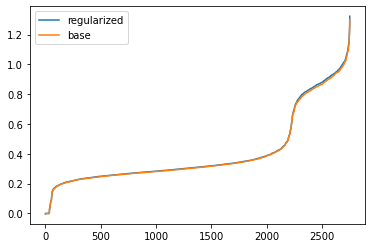

In [14]:
plt.plot(sorted(bn), label='regularized')
plt.plot(sorted(bn_base), label='base')
plt.legend()
plt.show()